# 1.- Load dependencies

In [1]:
import os
import sys

# add subpath to notebooks
sys.path.append(os.path.abspath(os.path.join('..')))
# sys.path.append(os.path.abspath(os.path.join('../utils')))
sys.path.append('../')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils.paths import list_images
from dense10_segmentator import DenseSegmentator

import tensorflow as tf

from tensorflow.compat.v1.keras.backend import set_session
from tensorflow.compat.v1 import Session
from tensorflow.compat.v1 import ConfigProto

config = ConfigProto()
# dynamically grow GPU memory
config.gpu_options.allow_growth = True
set_session(Session(config=config))

%load_ext autoreload
%autoreload 2

2022-11-04 11:52:02.982331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 11:52:04.996822: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 11:52:05.042333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 11:52:05.070344: I tensorflow/stream_executor/cud

# 2.- Set path of weights and config file

In [2]:
# openeds config
# inifile_path = '../config/openeds_dense10.ini'
# modelpath = '../models/epoch_124_miou_0.9345.h5'

# alcohol config
inifile_path = '../config/segmentator_dense10.ini'
modelpath = '/home/choppy/TOC/densenet10/models/weights/dense_models/blurry_gemini_dense_miou_0.9275.h5'

# 3.- Instance and load model

In [3]:
model = DenseSegmentator(modelpath=modelpath, inifile_path=inifile_path)

2022-11-04 11:52:05.724350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 11:52:05.724822: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 11:52:05.725101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 11:52:05.725478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 11:52:05.725762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

# 4.- Show images examples

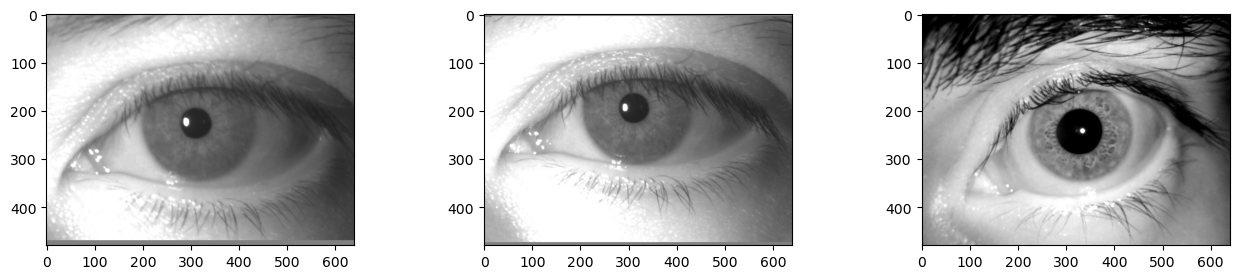

In [4]:
file1 = '.data/samples/0000784_LG_E_0_0_1_L_M_N_N_1981_9_2017.bmp'
file2 = '.data/samples/0000804_LG_E_0_0_2_L_M_N_N_1981_9_2017.bmp'
file3 = '.data/samples/0001367_Iritech_E_0_1_3_L_M_N_N_1982_56_2017.bmp'

samples = {
    'sample1': model.load_image(file1),
    'sample2': model.load_image(file2),
    'sample3': model.load_image(file3),
}

fig, axes = plt.subplots(1, 3, figsize=(16,3))

for ax, key_s in zip(axes, samples.keys()):
    ax.imshow(samples[key_s])

# 5. Get iris rubbersheet from each image example

2022-11-04 11:52:07.838215: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-11-04 11:52:08.305326: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-04 11:52:08.305705: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-04 11:52:08.305724: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-04 11:52:08.306057: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-04 11:52:08.306128: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


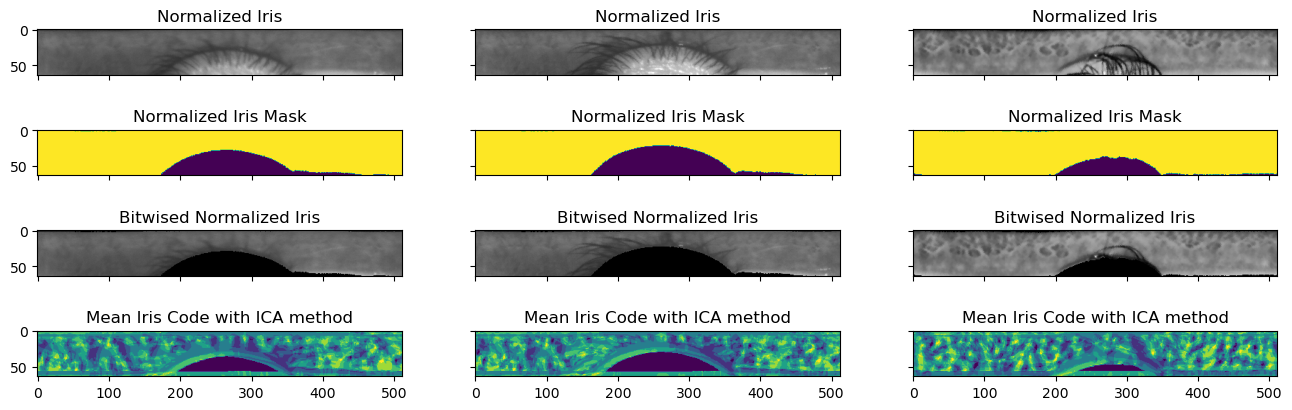

In [5]:
samples_info = {} # store inference data
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(16,5), sharex=True, sharey=True)
axes = axes.T # rotate grid because yes

for key_s, (ax1, ax2, ax3, ax4) in zip(samples, axes):
    image = samples[key_s].copy()
    info = model.forward(image)
    samples_info[key_s] = info # store data
    
    iris_rs = info.get('iris_rubbersheet')
    mask_iris_rs = info.get('mask_iris_rubbersheet')
    bw_iris = info.get('bitwised_iris_rubbersheet')
    
    ax1.imshow(iris_rs)
    ax1.set_title('Normalized Iris')
    
    ax2.imshow(mask_iris_rs)
    ax2.set_title('Normalized Iris Mask')
    
    ax3.imshow(bw_iris)
    ax3.set_title('Bitwised Normalized Iris')
    
    # get iris code with model function
    # this is not included on forward method because reasons
    iris_code = model.extract_code_ICA(bw_iris) # use filtered iris
    samples_info[key_s]['iris_code'] = iris_code
    ax4.imshow(iris_code.mean(axis=-1))
    ax4.set_title('Mean Iris Code with ICA method')

# Test hamming distance verification

In [6]:
# get stored data from dict
code_1 = samples_info.get('sample1').get('iris_code')
mask_1b = samples_info.get('sample1').get('mask_iris_rubbersheet')[..., 0]

code_2 = samples_info.get('sample2').get('iris_code')
mask_2b = samples_info.get('sample2').get('mask_iris_rubbersheet')[..., 0]

code_3 = samples_info.get('sample3').get('iris_code')
mask_3b = samples_info.get('sample3').get('mask_iris_rubbersheet')[..., 0]

In [7]:
# test im1 vs im2
score_12 = model.matchCodes(code_1, code_2, mask_1b, mask_2b)

# test im1 vs im2
score_13 = model.matchCodes(code_1, code_3, mask_1b, mask_3b)

# test im1 vs im3
score_23 = model.matchCodes(code_2, code_3, mask_2b, mask_3b)

# Asignar si el match es genuino o impostor
th = 0.3
match_12 = 'accepted' if score_12 < th else 'rejected'
match_13 = 'accepted' if score_13 < th else 'rejected'
match_23 = 'accepted' if score_23 < th else 'rejected'

print("im1 vs im2: HD = {:0.4f} ({})".format(score_12, match_12))
print("im1 vs im3: HD = {:0.4f} ({})".format(score_13, match_13))
print("im2 vs im3: HD = {:0.4f} ({})".format(score_23, match_23))

im1 vs im2: HD = 0.1404 (accepted)
im1 vs im3: HD = 0.4424 (rejected)
im2 vs im3: HD = 0.4414 (rejected)


In [8]:
code_3.shape

(64, 512, 7)